In [1232]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy import integrate
import scipy.integrate as integrate
from tqdm import tqdm
import statistics
import corner

In [1233]:
data_dl_old = np.array([     40.53806137,   62.07017585,   61.0243238 , 69.31112943  ,
                         86.25076898,  101.13069126,  116.81617341,  146.8192414 ,
                        170.23269545,  201.3738048 ,  222.4861474 ,  280.98489615,
                        318.50992938,  405.88497578,  465.31063183,  549.11458077,
                        677.11584355,  768.00310486,  945.15486863, 1117.84857053,
                       1349.22063847, 1578.1307268 , 2001.53401815, 2372.8100645 ,
                       2906.58465084, 3471.22668519, 4242.51098787, 5223.03547744,
                       6480.41734566, 8315.77970426, 9582.15023658])

In [1234]:
data_dl = data_dl_old * 67.3 / 73
print(data_dl)

[  37.37276069   57.22360048   56.25941085   63.89916453   79.5161199
   93.23418523  107.69491055  135.35527324  156.94055348  185.65009675
  205.11394137  259.0449796   293.63997599  374.19258726  428.97815784
  506.23851076  624.2451544   708.03573914  871.35510492 1030.56450406
 1243.87053382 1454.90682073 1845.24985509 2187.53585398 2679.63215071
 3200.18569744 3911.24643128 4815.20941961 5974.41215566 7666.46539858
 8833.95494413]


In [1235]:
delta_dl = np.array([   2.72346151,   4.79634547,   2.20603503,   2.30946165,
                        3.39449223,   2.61388012,   3.28521861,   3.83796674,
                        4.45249119,   6.96847286,   9.51854653,   8.03423717,
                        9.66313141,  10.21509654,  12.84279292,   9.4662071 ,
                       12.04078295,  12.26860817,  13.98936404,  16.96826551,
                       19.70873491,  28.53401192,  30.94814492,  45.37042514,
                       52.69970136,  57.46065654, 122.65212034, 131.30859924,
                      199.43646926, 592.06360303, 610.95412592])

In [1236]:
data_z = np.array([0.01 , 0.012, 0.014, 0.016, 0.019, 0.023, 0.026, 0.031, 0.037,
                   0.043, 0.051, 0.06 , 0.07 , 0.082, 0.097, 0.114, 0.134, 0.158,
                   0.186, 0.218, 0.257, 0.302, 0.355, 0.418, 0.491, 0.578, 0.679,
                   0.799, 0.94 , 1.105, 1.3  ])

Text(0.5, 0, '$z$')

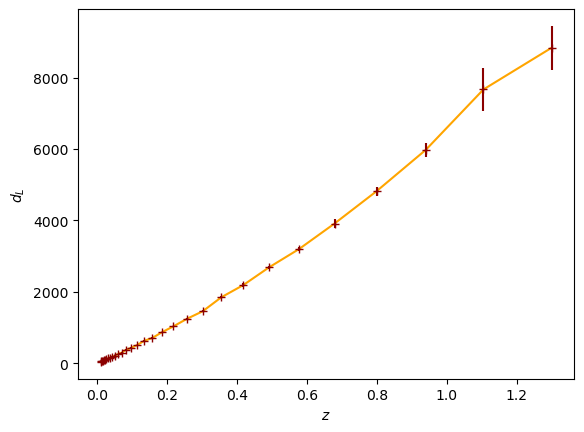

In [1237]:
plt.plot(data_z,data_dl, color="orange")
plt.errorbar(data_z, data_dl, yerr=delta_dl,fmt ='+', color="darkred")
plt.ylabel("$d_L$")
plt.xlabel("$z$")

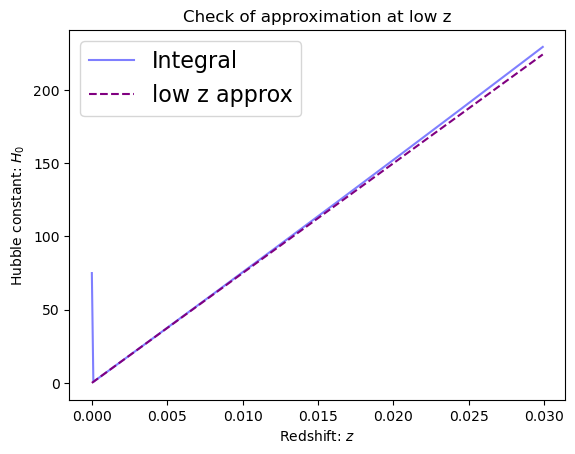

In [1238]:
c = 3e5
omega_prop = 0.3

delta_z = 1e-4
z_range = np.arange(0,0.03,delta_z)
D_l = 40

integrand = 1/(np.sqrt(omega_prop*((z_range+1)**3)+1-omega_prop))

H0_int = (c*(1 + z_range)/D_l) * integrate.cumtrapz(integrand, z_range, initial = 0.01)

H0_low = (c*z_range)/D_l

plt.plot(z_range,H0_int,color = 'blue', alpha = 0.5, label = 'Integral')
plt.plot(z_range,H0_low, color = 'purple', linestyle = 'dashed', label = 'low z approx')
plt.xlabel(r'Redshift: $z$')
plt.ylabel(r'Hubble constant: $H_{0}$')
plt.title('Check of approximation at low z')
plt.legend(fontsize = 16)

In [1239]:
def llike(data_dl, data_z, H0_prop, omega_prop, delta_dl, N_obs):
        
    # Calculate initial point
    #z_array = np.arange(0,0.01,1e-4)
    #init_func = 1/(np.sqrt(omega_prop*((z_array+1)**3)+1-omega_prop))
    
    #init_point = integrate.simps(z_array,init_func)
    c = 3e5

    func = 1/(np.sqrt(omega_prop*((data_z+1)**3)+1-omega_prop))
    
    integ = integrate.cumtrapz(func, data_z, initial = 0) 
    
    init_point = 0.5*0.01*(func[0] + 1)
    first_term = -(N_obs/2) * np.log(2 * np.pi) - np.log(np.prod(delta_dl))
    second_term = -np.sum((1/(2 * delta_dl**2)) * (data_dl - ((c/H0_prop)*((1+data_z)*(integ + init_point))))**2)
    

    return(first_term + second_term)

In [1240]:
def lprior_uniform(param, param_low_val, param_high_val):
    """
    Set uniform priors on parameters with select ranges.
    """
    if param < param_low_val or param > param_high_val:
        return -np.inf
    else:
        return 0

In [1241]:
def lpost(data_dl, data_z, H0_prop, omega_prop, delta_dl, N_obs, param1, param2, 
          param1_low_range = 0, param1_high_range = 100, 
          param2_low_range = 0, param2_high_range = 10):
    '''
    Compute log posterior - require log likelihood and log prior.
    '''
    return(lprior_uniform(param1, param1_low_range, param1_high_range) 
           +lprior_uniform(param2, param2_low_range, param2_high_range) 
           + llike(data_dl, data_z, H0_prop, omega_prop, delta_dl, N_obs))

In [1242]:
def accept_reject(lp_prop, lp_prev):
    '''
    Compute log acceptance probability (minimum of 0 and log acceptance rate)
    Decide whether to accept (1) or reject (0)
    '''
    u = np.random.uniform(size = 1)  # U[0, 1]
    logalpha = np.minimum(0, lp_prop - lp_prev)  # log acceptance probability
    if np.log(u) < logalpha:
        return(1)  # Accept
    else:
        return(0)  # Reject

In [1243]:
def MCMC_run(data_dl, data_z, delta_dl, Ntotal, burnin, N_obs, param_start, H0_var_prop, omega_var_prop, printerval):
    '''
    Metropolis MCMC sampler
    '''

    # Set starting values

    H0_chain = [param_start[0]]
    omega_chain = [param_start[1]]
                                           
    # Initial value for log posterior
    lp = []
    lp.append(lpost(data_dl, data_z, H0_chain[0], omega_chain[0], delta_dl, N_obs, H0_chain[0], omega_chain[0])) # Append first value of log posterior 
    
    lp_store = lp[0]  # Create log posterior storage to be overwritten

    #####                                                  
    # Run MCMC
    #####
    accept_reject_count = [1]

    for i in tqdm(range(1, Ntotal)):
        
        if i % printerval == 0: # Print accept/reject ratio.
            # tqdm.write("Iteration ", i, "accept_reject =",sum(accept_reject_count)/len(accept_reject_count))
            accept_reject_ratio = sum(accept_reject_count)/len(accept_reject_count)
            tqdm.write("Iteration {0}, accept_reject = {1}".format(i,accept_reject_ratio))
            # print("Iteration ", i, "accept_reject =",sum(accept_reject_count)/len(accept_reject_count))
            
        lp_prev = lp_store  # Call previous stored log posterior
        
        # Propose new points according to a normal proposal distribution of fixed variance 
        
        H0_prop = np.random.normal(H0_chain[i - 1], np.sqrt(H0_var_prop))
        omega_prop = np.random.normal(omega_chain[i - 1], np.sqrt(omega_var_prop))
#         omega_prop = 0.3
        # Compute log posterior
        lp_prop = lpost(data_dl, data_z, H0_prop, omega_prop, delta_dl, N_obs, H0_prop, omega_prop)
        
        if accept_reject(lp_prop, lp_prev) == 1:  # Accept
            H0_chain.append(H0_prop)    # accept H0_{prop} as new sample
            omega_chain.append(omega_prop)      # accept omega_{prop} as new sample
            accept_reject_count.append(1)
            lp_store = lp_prop  # Overwrite lp_store
            
        else:  # Reject, if this is the case we use previously accepted values
            H0_chain.append(H0_chain[i - 1])
            omega_chain.append(omega_chain[i - 1])
            accept_reject_count.append(0)

        lp.append(lp_store)
    
    # Recast as np.arrays

    H0_chain = np.array(H0_chain)
    omega_chain = np.array(omega_chain)
    
    H0_chain = H0_chain[burnin:]
    omega_chain = omega_chain[burnin:]

    
    return H0_chain, omega_chain, lp  # Return chains and log posterior.

In [1244]:
param_start =[65, 0.7]
Ntotal = 500000 # Total number of iterations
burnin = 30000  # Set burn-in. This is the amount of samples we will discard whilst looking 
                # for the true parameters
H0_var_prop = 0.5257681419694549**2
omega_var_prop = 0.030541542883896072**2
printerval = 100000

N_obs = len(data_z)

In [1245]:
H0_chain, omega_chain, lp = MCMC_run(data_dl, data_z, delta_dl, Ntotal, burnin, N_obs,
                           param_start, H0_var_prop, omega_var_prop, printerval)

 21%|████████████████████████████████▊                                                                                                                           | 105066/499999 [00:03<00:14, 28070.36it/s]

Iteration 100000, accept_reject = 0.40974


 41%|███████████████████████████████████████████████████████████████▉                                                                                            | 204965/499999 [00:07<00:10, 28585.79it/s]

Iteration 200000, accept_reject = 0.409735


 61%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                             | 303328/499999 [00:10<00:06, 28613.77it/s]

Iteration 300000, accept_reject = 0.4106766666666667


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 404737/499999 [00:14<00:03, 27192.14it/s]

Iteration 400000, accept_reject = 0.410885


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 499999/499999 [00:17<00:00, 28828.64it/s]


mean of H0 = 73.31871160943108 _ standard deviation of H0 = 0.5290943815255246
mean of omega = 0.2881528950816854 _ standard deviation of omega = 0.03064880339206365


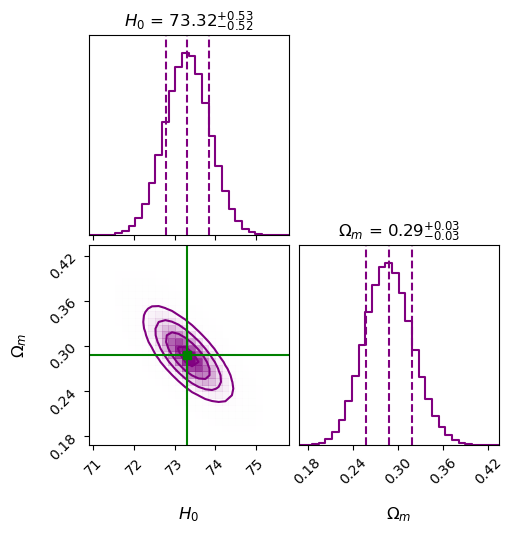

In [1246]:
#fig, ax = plt.subplots(1,2, figsize = (16,8))
#ax[0].hist(H0_chain, bins = 60, color = 'turquoise', edgecolor = 'darkcyan', alpha = 0.75)
#ax[1].hist(omega_chain, bins = 60, color = 'purple', edgecolor = 'rebeccapurple', alpha = 0.75)

ma = statistics.mean(H0_chain)
sda = statistics.stdev(H0_chain)

mb = statistics.mean(omega_chain)
sdb = statistics.stdev(omega_chain)


print("mean of H0 =", ma, '_', "standard deviation of H0 =", sda)
print("mean of omega =", mb, '_', "standard deviation of omega =", sdb)

samples = np.column_stack([H0_chain,omega_chain])

params = [r"$H_0$", r"$\Omega_m$"]

figure = corner.corner(samples, bins = 30, color = 'purple', labels = params, 
                plot_datapoints = False, smooth1d = True, smooth = True, quantiles=[0.16, 0.5, 0.84],
                show_titles = True, label_kwargs = {"fontsize":12}, title_fmt='.2f',title_kwargs={"fontsize": 12})

axes = np.array(figure.axes).reshape((2, 2))

m = [ma, mb]

# Loop over the diagonal
#for i in range(2):
#    ax = axes[i, i]
#    ax.axvline(m[i], color="g")

# Loop over the histograms
for yi in range(2):
    for xi in range(yi):
        ax = axes[yi, xi]
        ax.axvline(m[xi], color="g")
        ax.axhline(m[yi], color="g")
        ax.plot(m[xi], m[yi], "sg")



(0.0, 200.0)

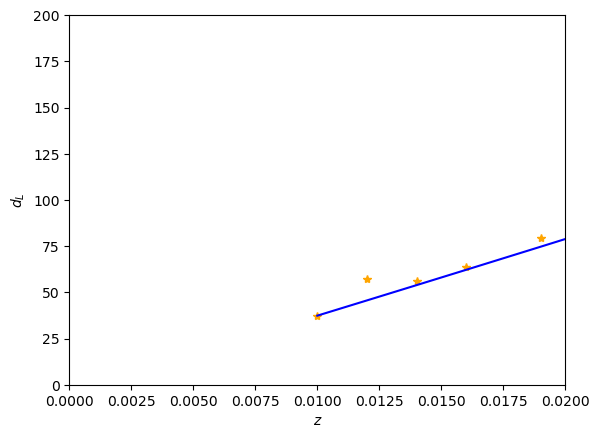

In [1224]:
H0_mean = np.mean(H0_chain)
omega_m_mean = np.mean(omega_chain)

func = 1/(np.sqrt(omega_m_mean*((data_z+1)**3)+1-omega_m_mean))
integ = integrate.cumtrapz(func, data_z, initial=0)

data_dl_mcmc = data_dl[0] + (c/H0_mean)*(1+data_z)*(integ)

plt.plot(data_z,data_dl, '*',color="orange", label = 'data')
plt.plot(data_z,data_dl_mcmc, color = 'blue', label = 'MCMC')
# plt.errorbar(data_z, data_dl, yerr=delta_dl,fmt ='+', color="darkred")
plt.ylabel("$d_L$")
plt.xlabel("$z$")
plt.xlim([0,0.02])
plt.ylim([0,200])

In [1131]:
101/200

0.505

0.9954856046960626
0.009977428023480313


(0.0, 200.0)

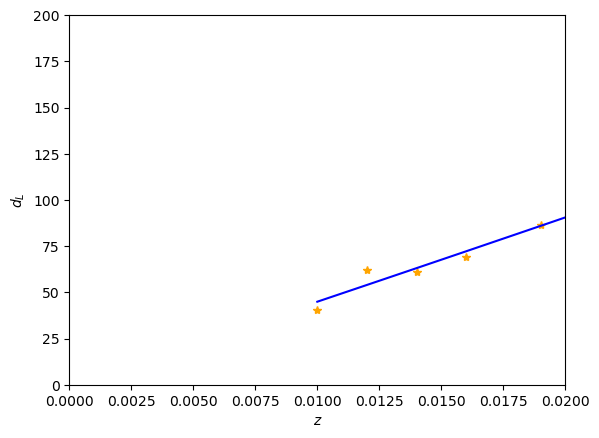

In [1136]:
H0_mean = 67.3 + 0*np.mean(H0_chain)
omega_m_mean = 0.3 + 0*np.mean(omega_chain)

func = 1/(np.sqrt(omega_m_mean*((data_z+1)**3)+1-omega_m_mean))
integ = integrate.cumtrapz(func, data_z, initial=0)

print(func[0])
init_point =  0.01*(func[0] + 1)/2

print(init_point)

data_dl_mcmc =(c/H0_mean)*(1+data_z)*(integ + init_point)

plt.plot(data_z,data_dl, '*',color="orange", label = 'data')
plt.plot(data_z,data_dl_mcmc, color = 'blue', label = 'MCMC')
# plt.errorbar(data_z, data_dl, yerr=delta_dl,fmt ='+', color="darkred")
plt.ylabel("$d_L$")
plt.xlabel("$z$")
plt.xlim([0,0.02])
plt.ylim([0,200])

Text(0.5, 0, '$z$')

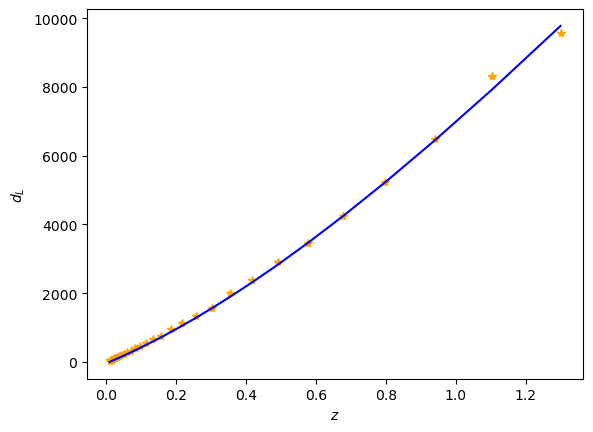

In [1105]:
H0_mean = np.mean(H0_chain)
omega_m_mean = np.mean(omega_chain)

func = 1/(np.sqrt(omega_m_mean*((data_z+1)**3)+1-omega_m_mean))
integ = integrate.cumtrapz(func, data_z, initial=0)

data_dl_mcmc = (c/H0_mean)*(1+data_z)*(integ)

plt.plot(data_z,data_dl, '*',color="orange", label = 'data')
plt.plot(data_z,data_dl_mcmc, color = 'blue', label = 'MCMC')
# plt.errorbar(data_z, data_dl, yerr=delta_dl,fmt ='+', color="darkred")
plt.ylabel("$d_L$")
plt.xlabel("$z$")

In [ ]:
data_dl_mcmc

In [1173]:
z_array = np.arange(0,0.01,1e-9)
delta_z = z_array[1] - z_array[0]
omega_prop = 0.3
init_func = 1/(np.sqrt(omega_prop*((z_array+1)**3)+1-omega_prop))

init_point_acc = integrate.simps(init_func,z_array)
print(init_point_acc)

0.009977450828754779


In [1163]:
init_point_not_acc =  0.01*(func[0] + 1)/2
print(init_point_not_acc)

0.009977428023480313
